### This is PyTorch implementaion of the experiment described in the paper [The Mechanics of n-Player Differentiable Games](https://arxiv.org/abs/1802.05642)

The main goal of the following experiment is to answer the following questions regarding Symplectic Gradient Adjustment:

 - 1) Will it reduce mode collapse?
 - 2) Does it accelerate learning process and improve generator quality?
 
 Some hyperparameters and code for __x_real_gen__ I took [here](https://github.com/deepmind/symplectic-gradient-adjustment/blob/master/Symplectic_Gradient_Adjustment.ipynb)
 

In [4]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import urllib
import requests
from IPython.core.display import clear_output

from os import path
# нужна информация о нашей системе
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

# уточним на чем будем вычислять
accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl torchvision
import torch
import torchvision
from torch import nn
print('torch version',torch.__version__)
print('torchvision version',torchvision.__version__)
print('is cuda availible',torch.cuda.is_available())

torch version 0.4.0
torchvision version 0.2.1
is cuda availible False


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
cd gdrive/My\ Drive/

/content/gdrive/My Drive


# 1. Without SGA

We will use just a simple GAN

In [0]:
from torch import nn

class MLP(nn.Module):
  
  def __init__(self, latent_dim, output_dim):
    
    super(MLP, self).__init__()
    
    self.latent_dim = latent_dim
    self.output_dim = output_dim
    self.hidden_dim = 384
    
    self.main = nn.Sequential(
                nn.Linear(self.latent_dim, self.hidden_dim),
                nn.ReLU(True),
                nn.Linear(self.hidden_dim, self.hidden_dim),
                nn.ReLU(True),
                nn.Linear(self.hidden_dim, self.hidden_dim),
                nn.ReLU(True),
                nn.Linear(self.hidden_dim, self.hidden_dim),
                nn.ReLU(True),
                nn.Linear(self.hidden_dim, self.hidden_dim),
                nn.ReLU(True),
                nn.Linear(self.hidden_dim, self.hidden_dim),
                nn.ReLU(True),
                nn.Linear(self.hidden_dim, self.output_dim))

  def forward(self, inp):

      return self.main(inp)



In [0]:
def x_real_gen(batch_size):
    sigma = 0.1
    grid = np.array([
        [ 1.50,  1.50],
        [ 1.50,  0.50],
        [ 1.50, -0.50],
        [ 1.50, -1.50],
        [ 0.50,  1.50],
        [ 0.50,  0.50],
        [ 0.50, -0.50],
        [ 0.50, -1.50],
        [-1.50,  1.50],
        [-1.50,  0.50],
        [-1.50, -0.50],
        [-1.50, -1.50],
        [-0.50,  1.50],
        [-0.50,  0.50],
        [-0.50, -0.50],
        [-0.50, -1.50],
    ])
    
    temp = np.tile(grid, (batch_size // 16 + 1,1))
    mus = torch.FloatTensor(temp[0:batch_size,:])
    return torch.FloatTensor(mus + sigma*torch.randn([batch_size, 2]))

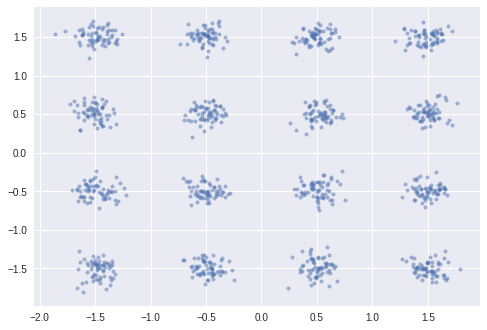

In [65]:
x = x_real_gen(1000)

plt.scatter(x[:,0], x[:,1], marker = '.', alpha = 0.5)

## Now let's apply the original algorithm from [here](https://arxiv.org/abs/1406.2661) 

![](https://cdn-images-1.medium.com/max/800/1*WnsJz9ZKS3dV3Nw36RtefQ.png)

 20%|█▉        | 1998/10000 [00:51<03:09, 42.18it/s]/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
100%|██████████| 10000/10000 [04:17<00:00, 42.68it/s]


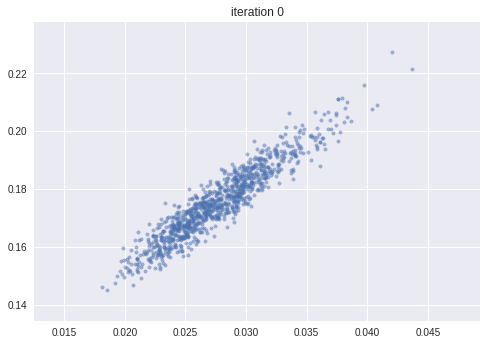

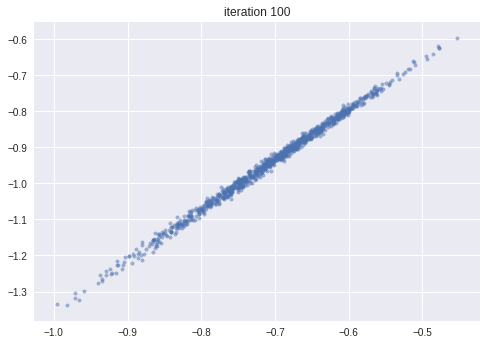

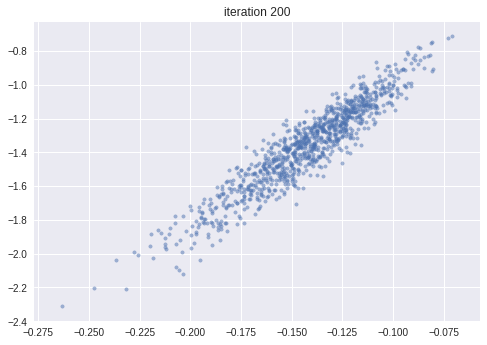

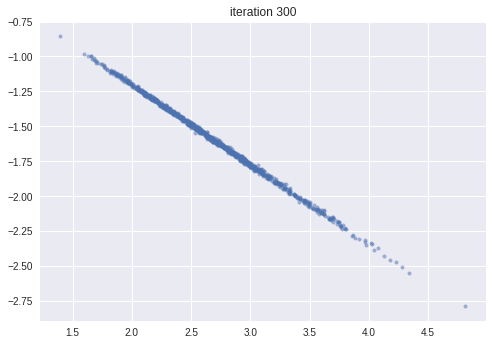

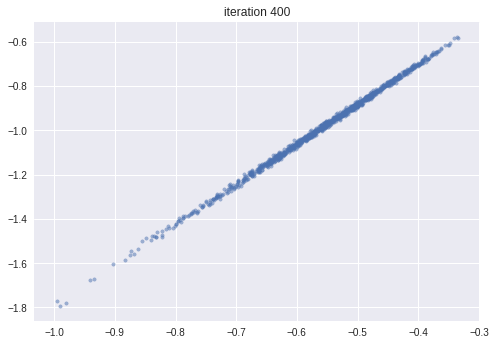

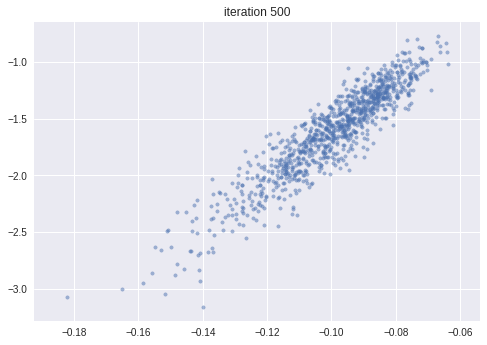

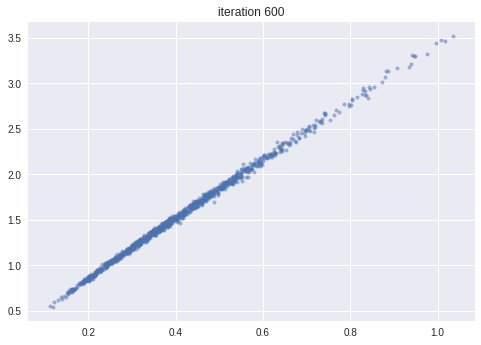

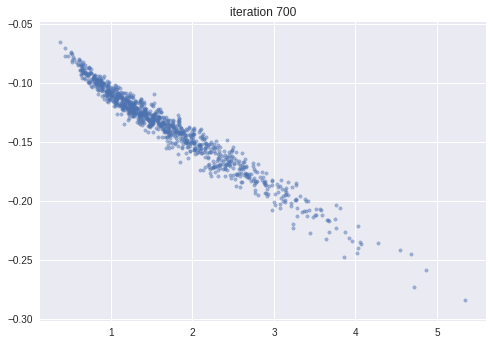

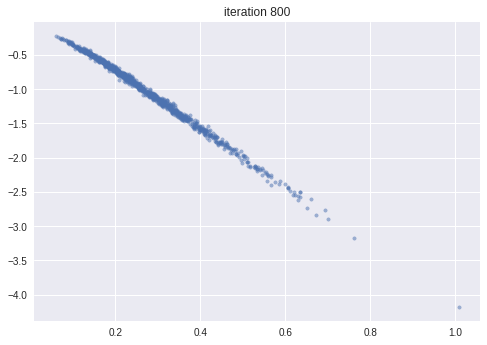

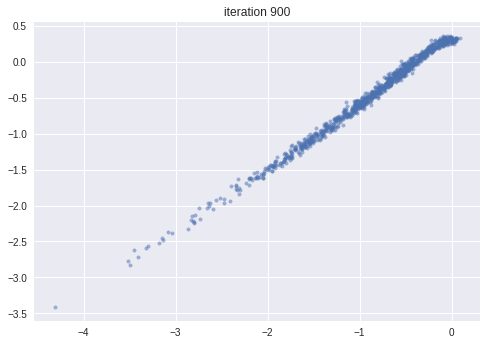

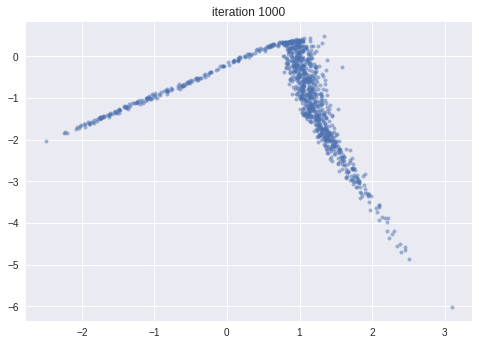

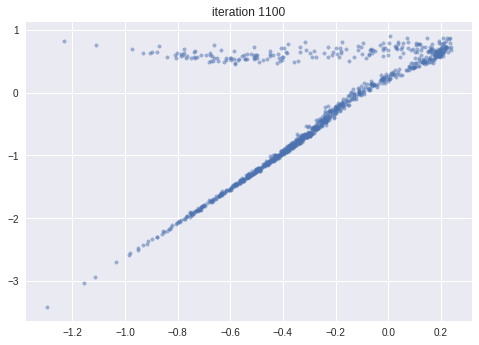

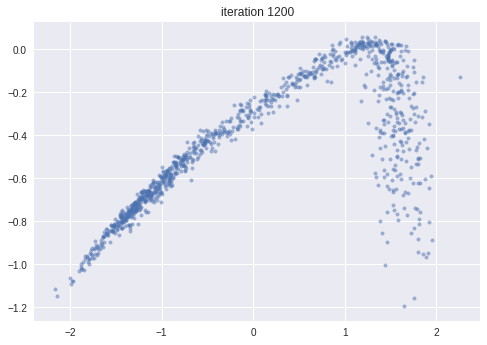

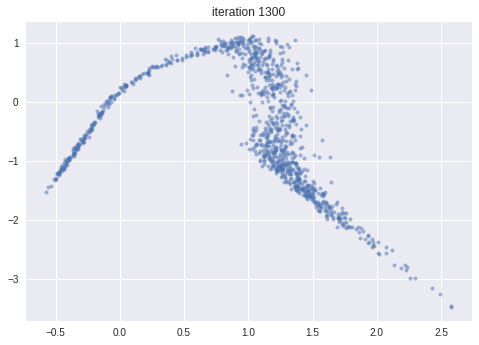

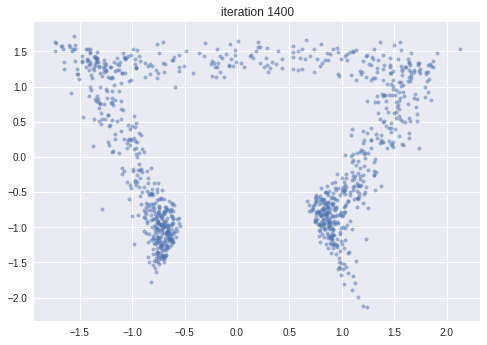

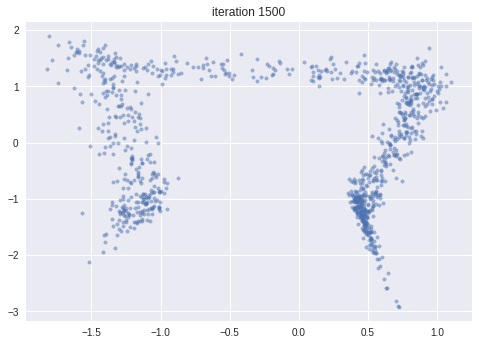

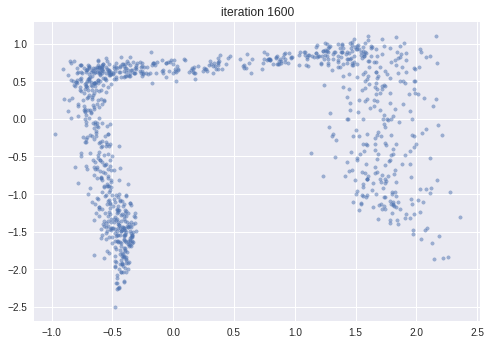

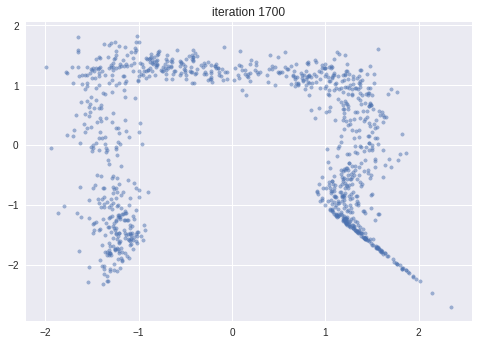

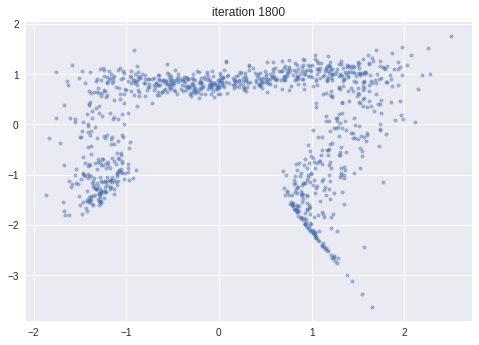

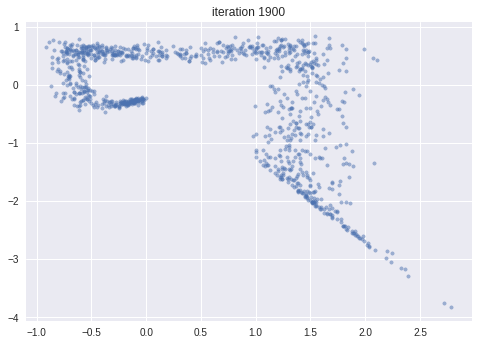

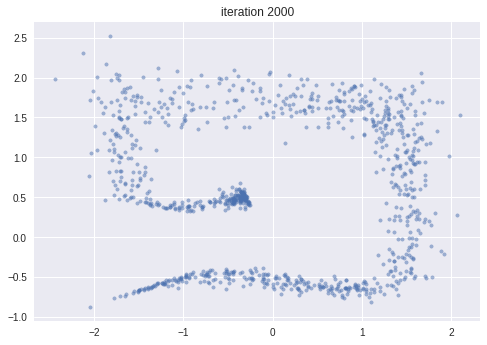

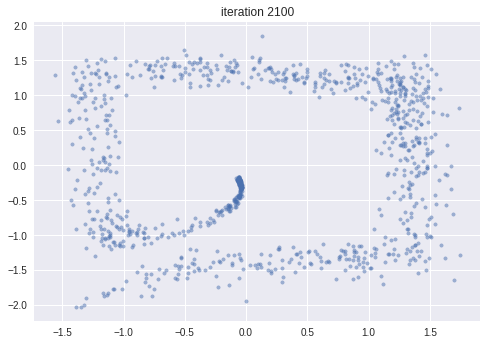

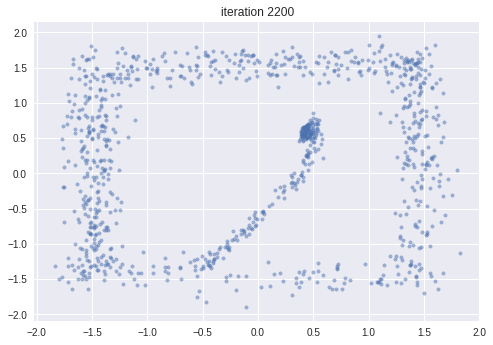

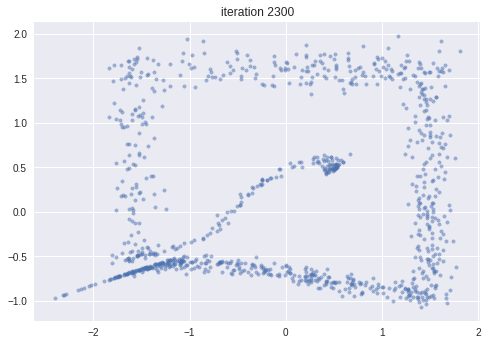

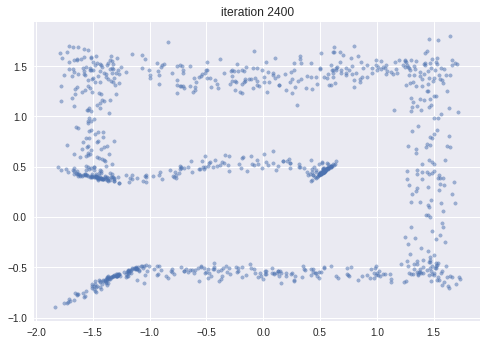

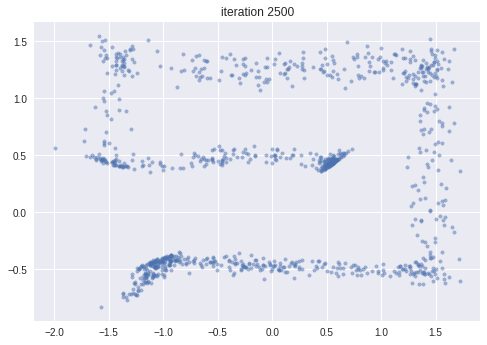

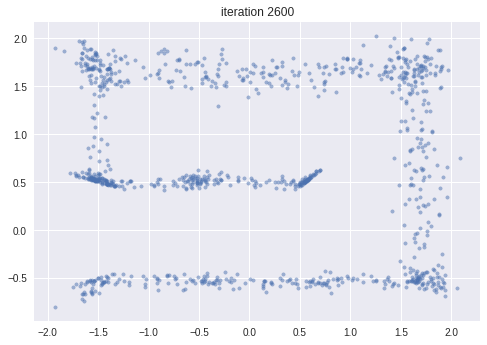

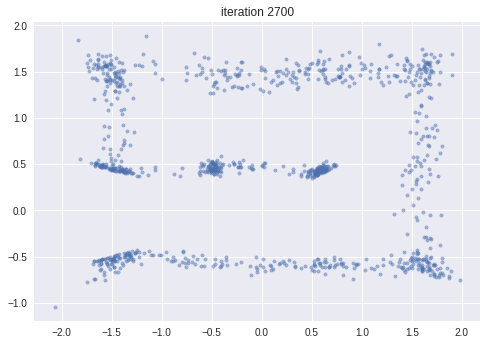

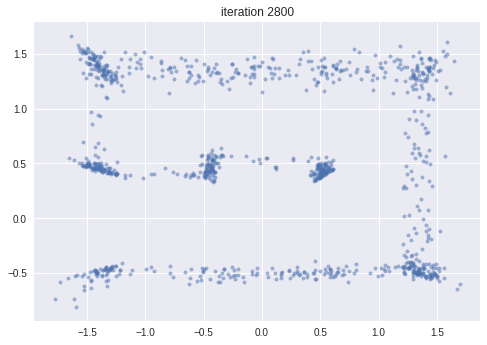

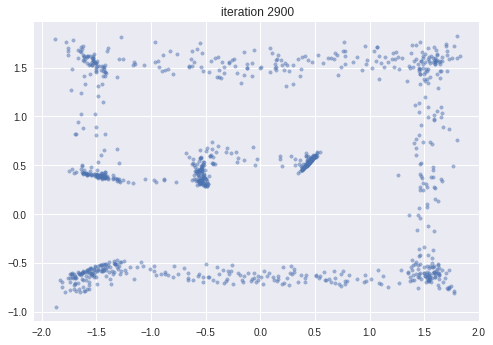

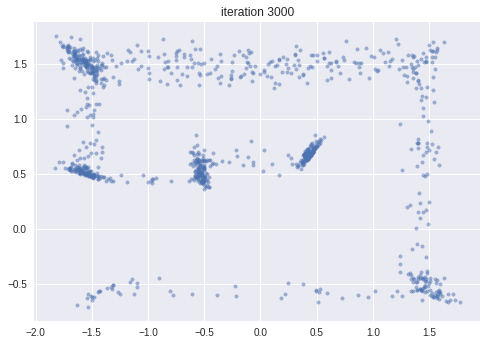

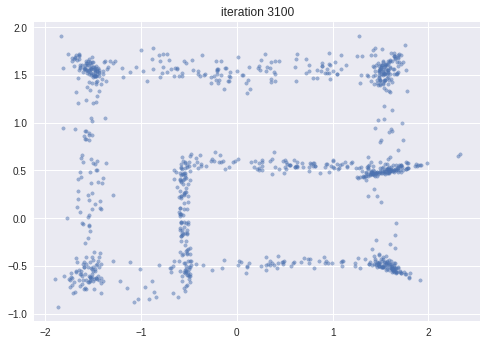

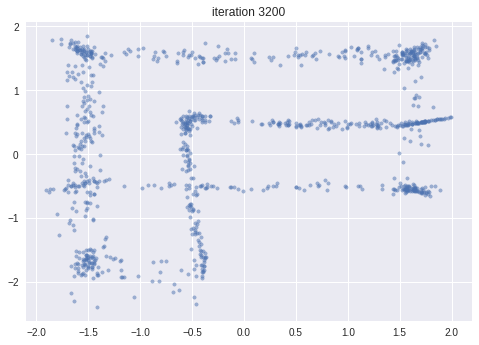

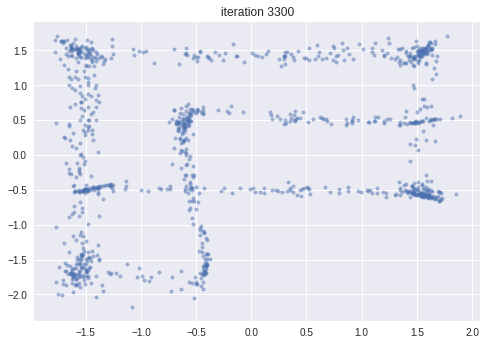

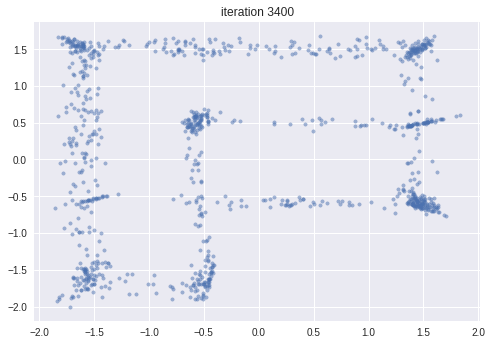

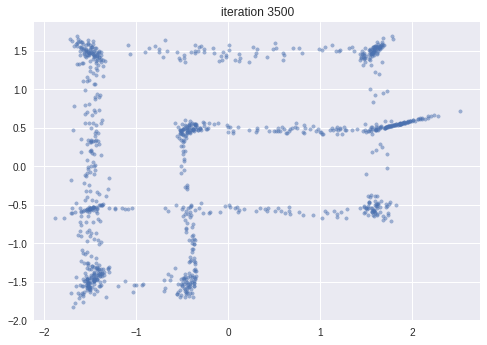

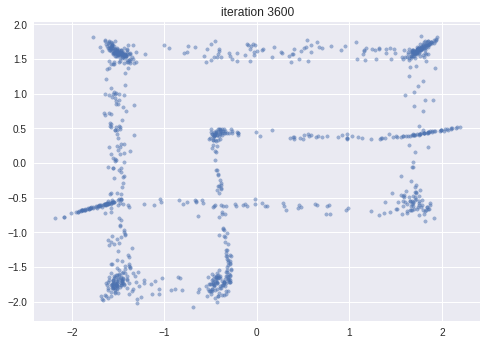

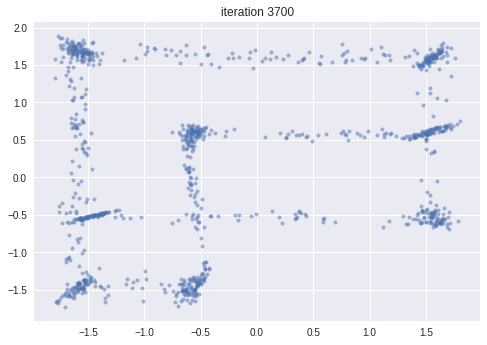

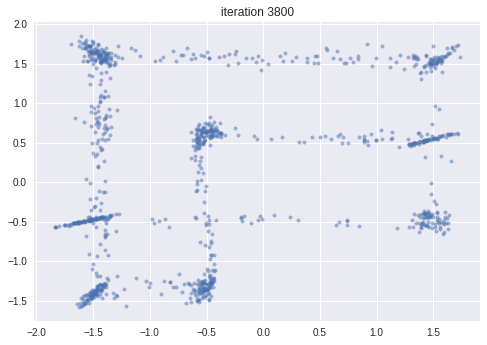

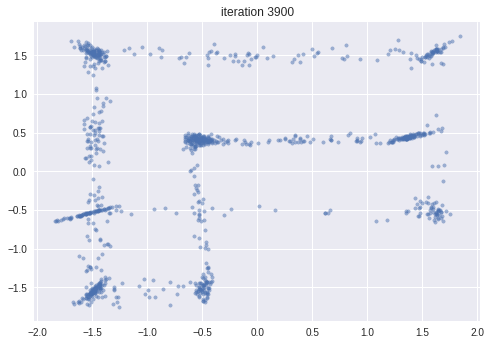

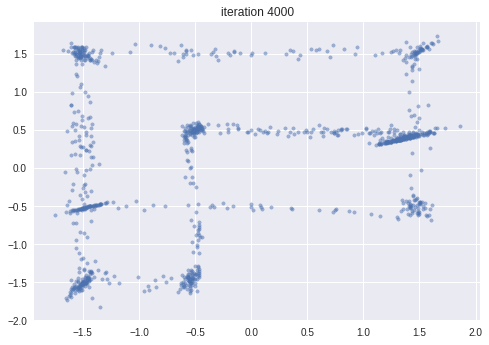

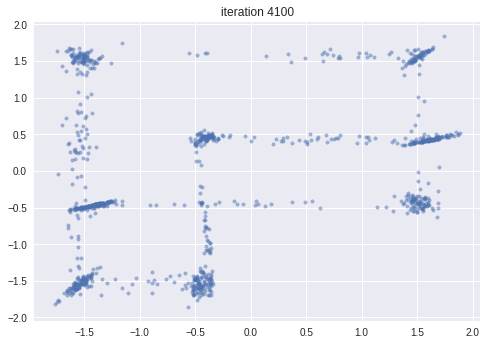

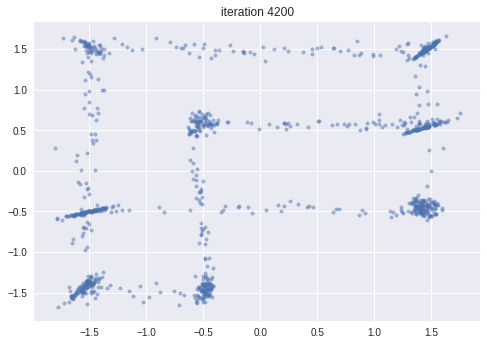

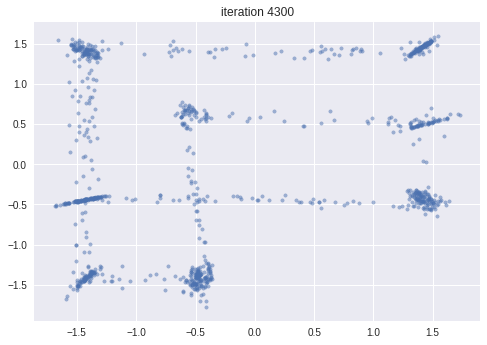

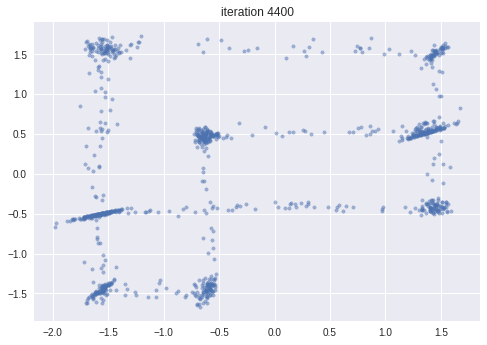

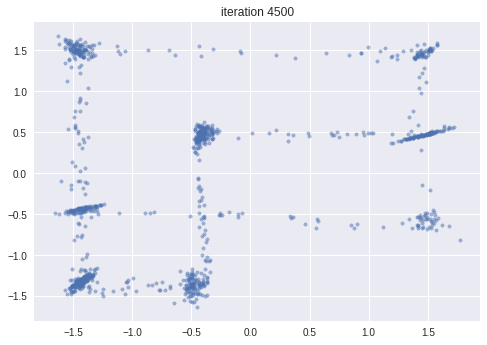

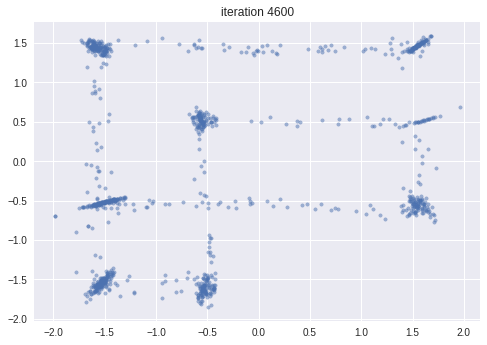

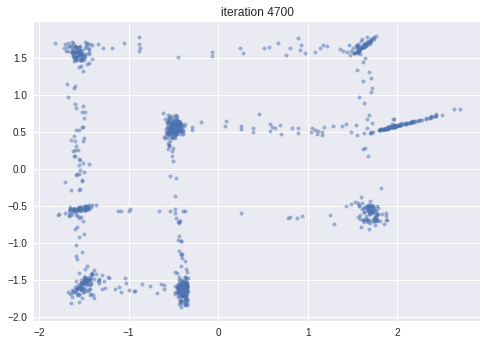

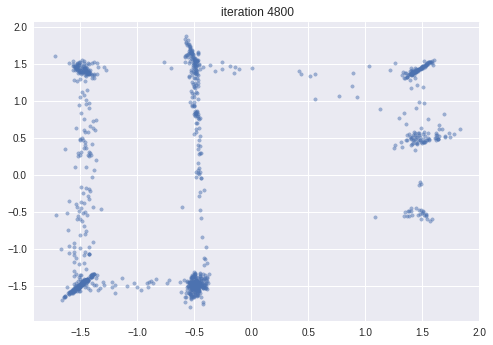

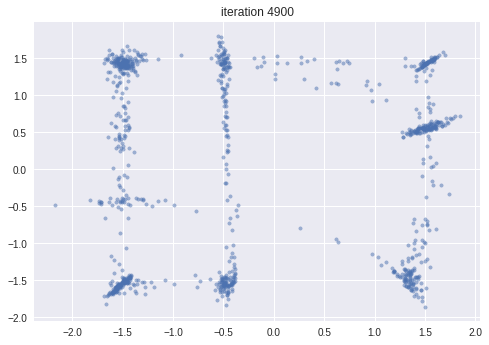

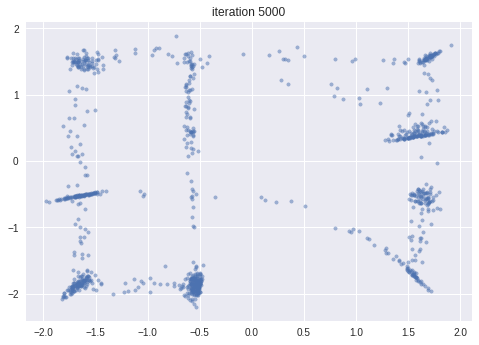

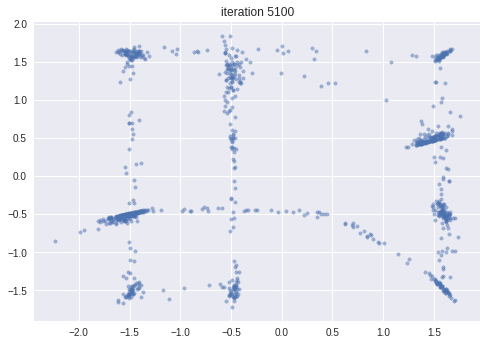

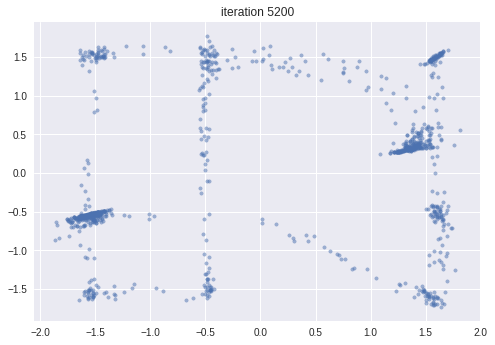

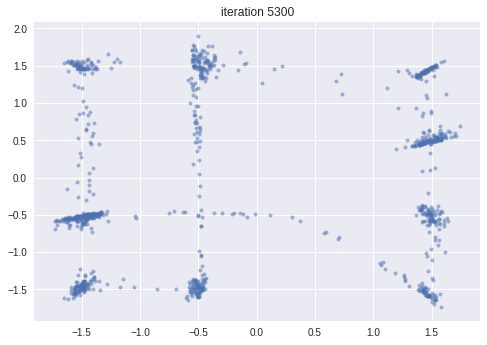

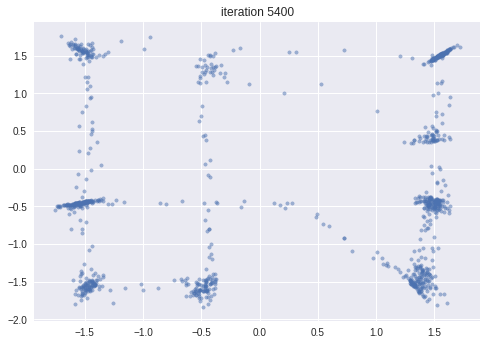

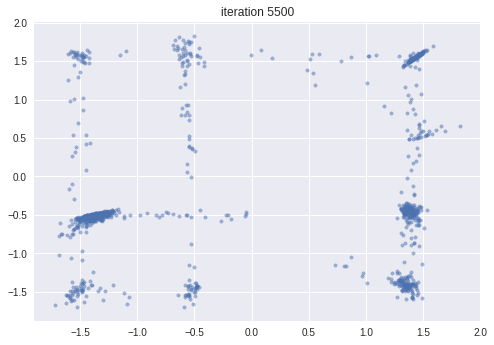

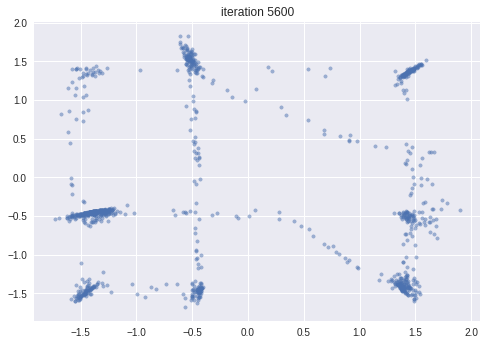

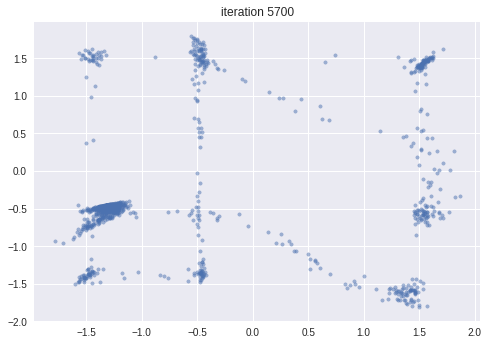

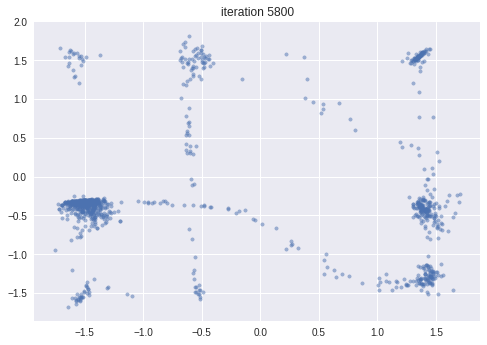

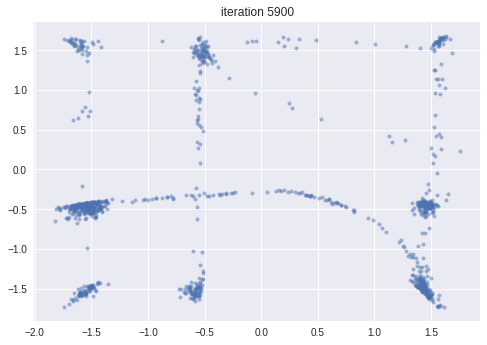

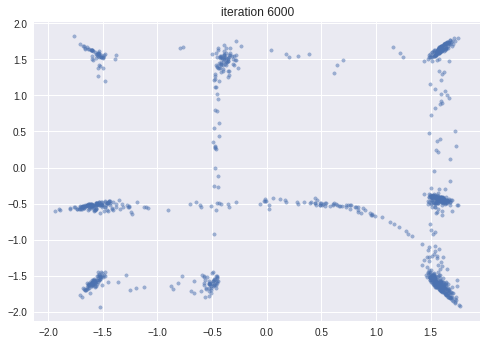

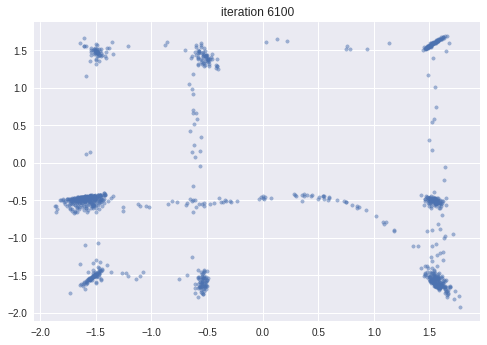

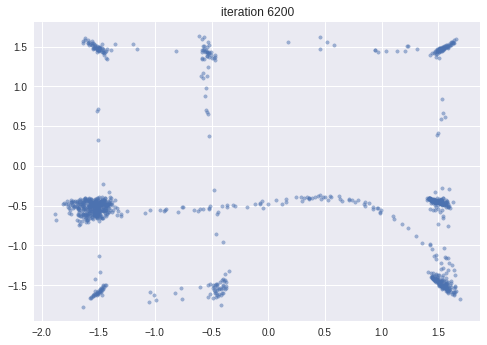

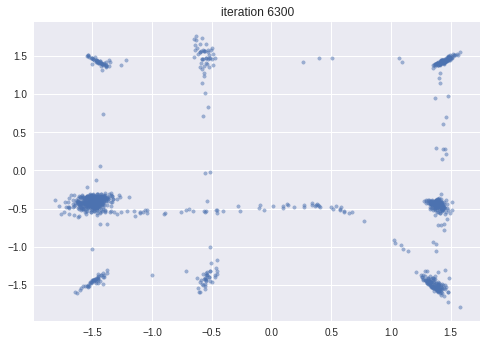

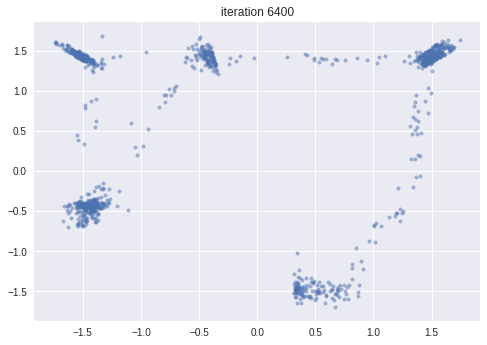

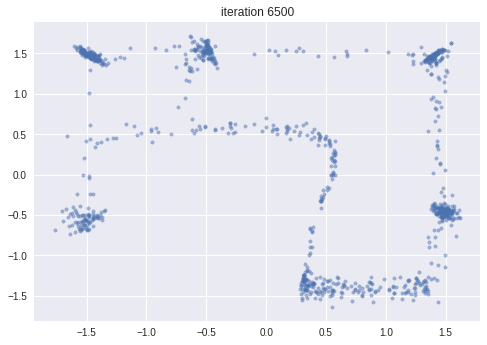

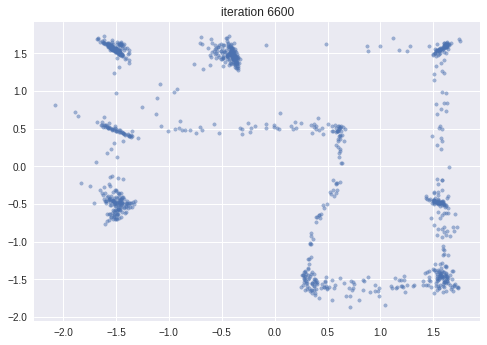

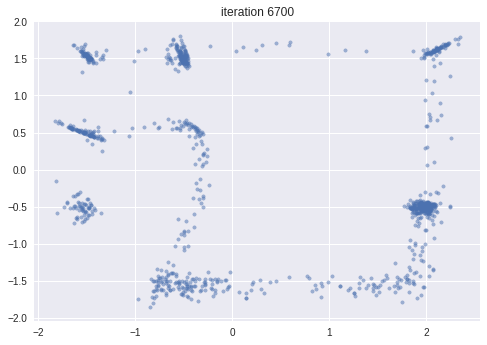

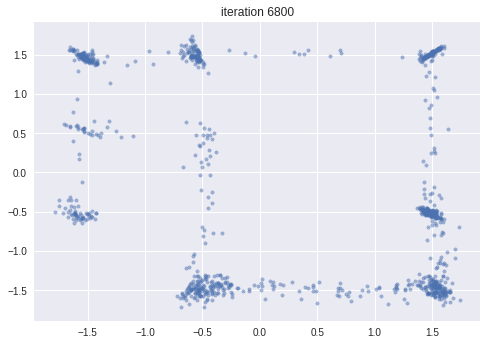

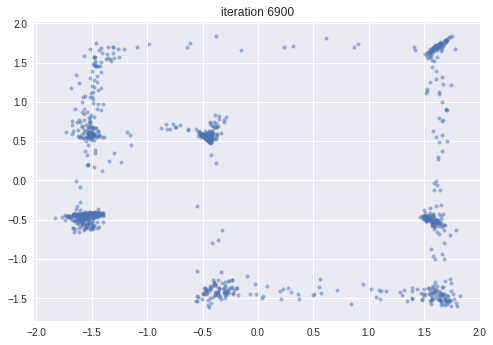

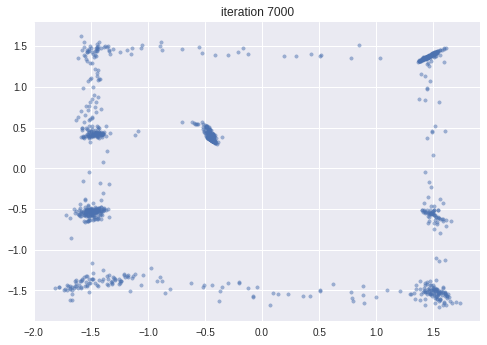

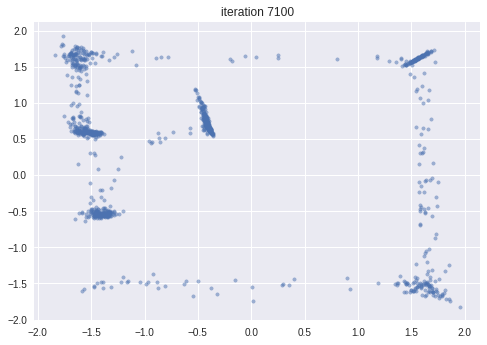

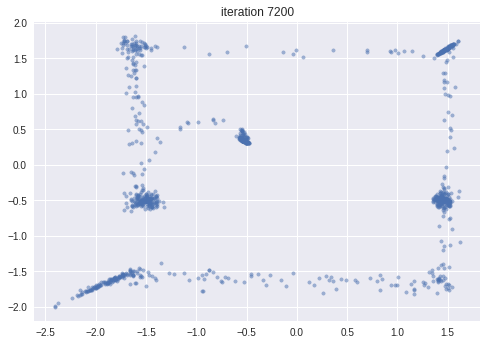

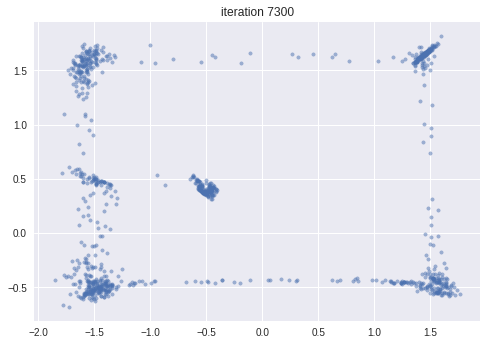

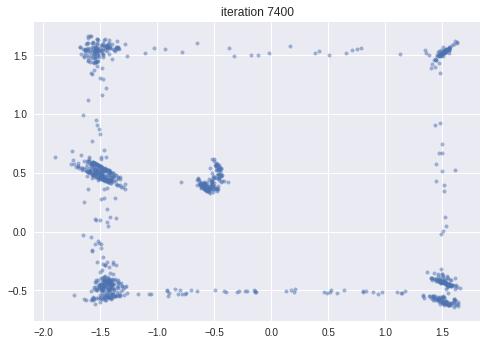

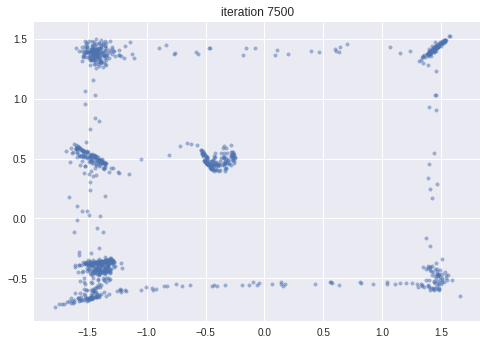

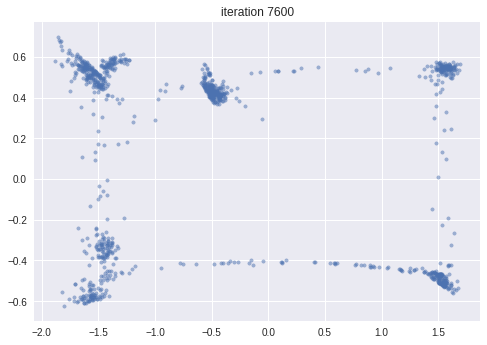

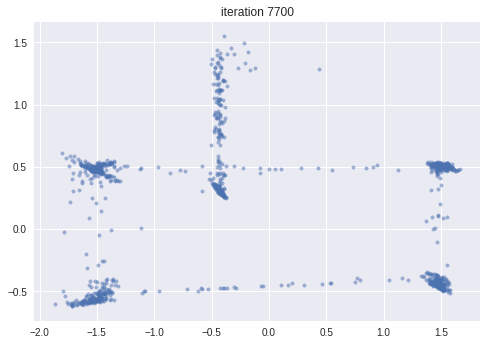

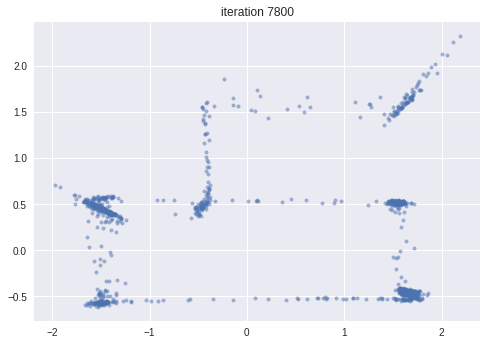

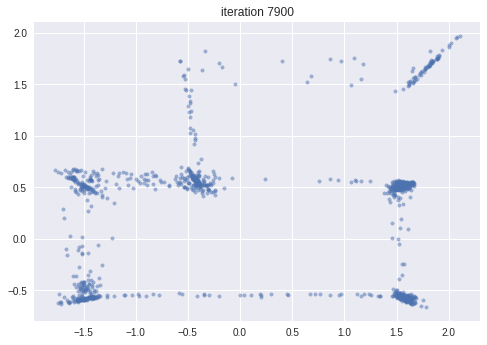

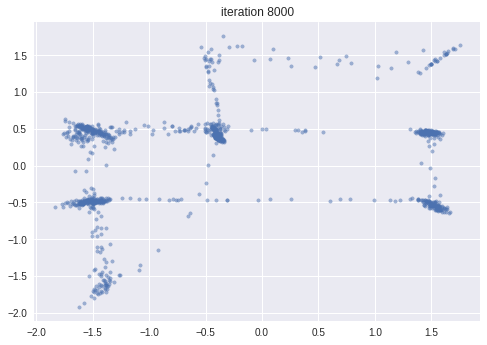

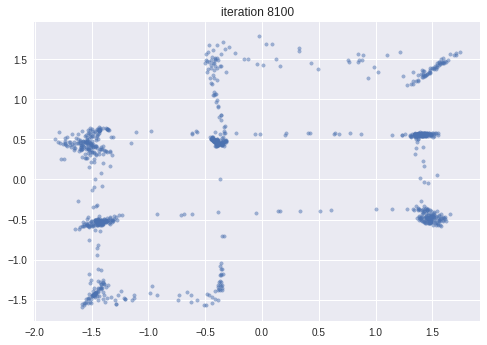

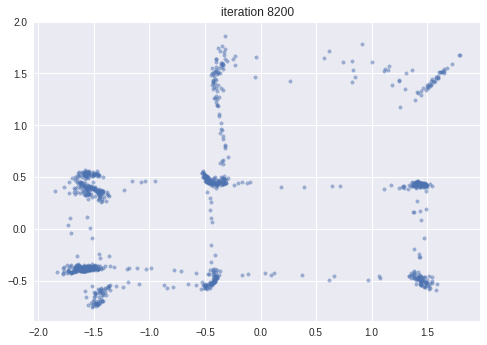

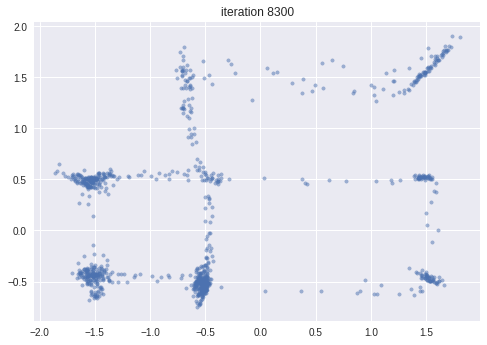

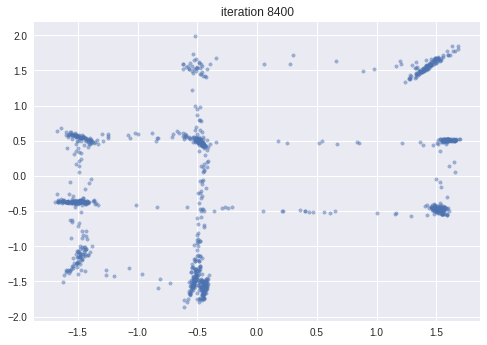

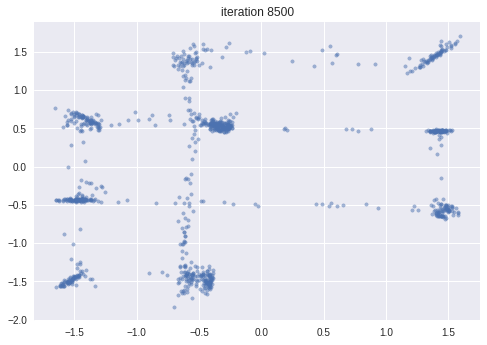

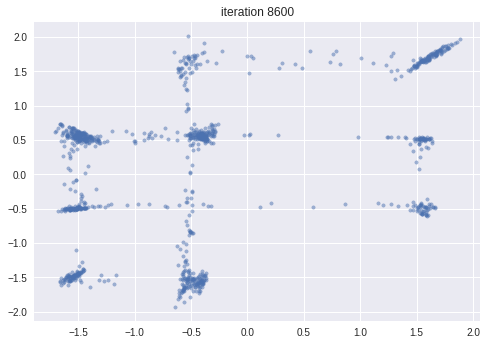

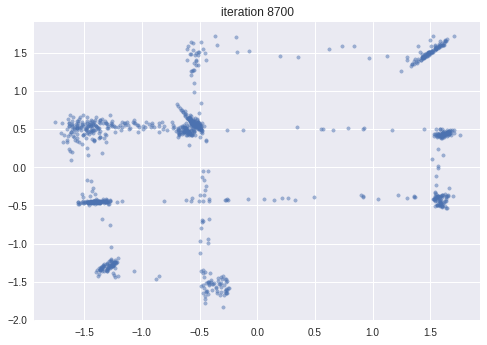

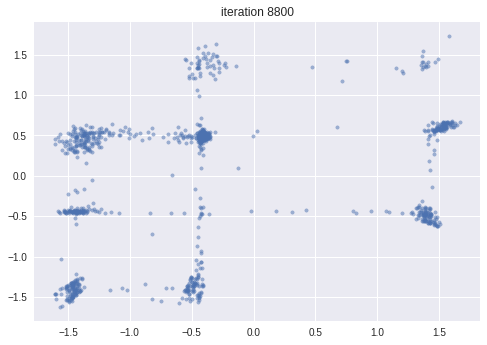

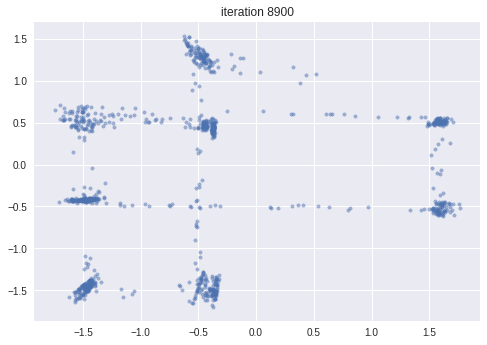

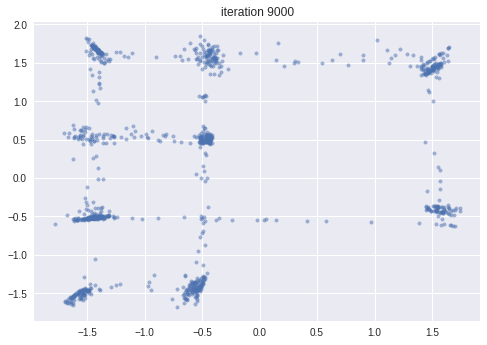

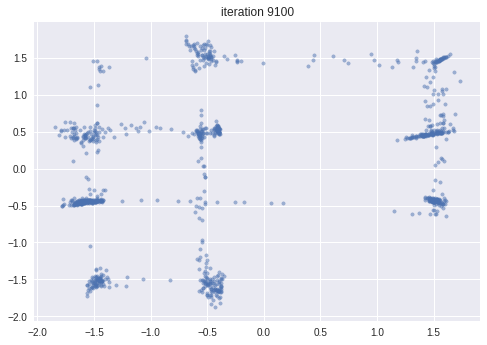

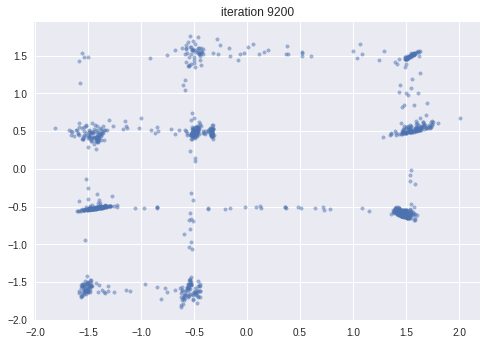

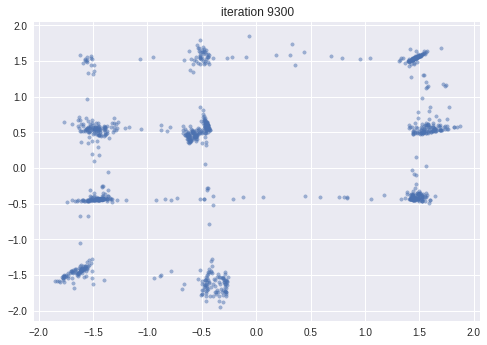

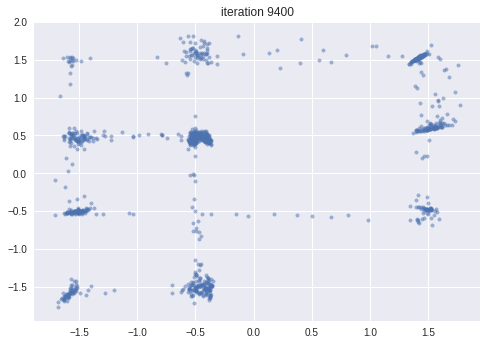

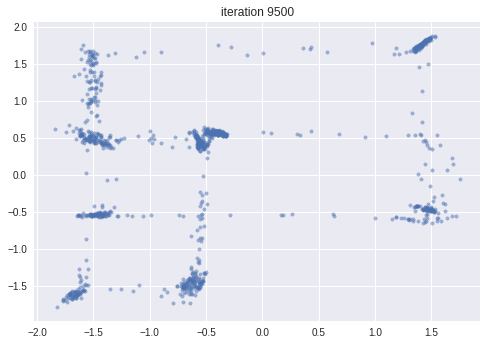

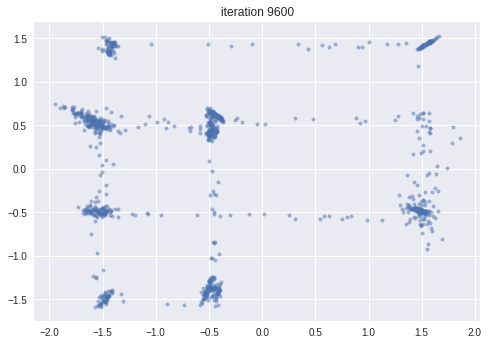

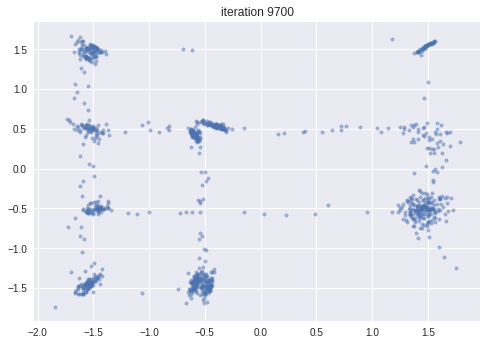

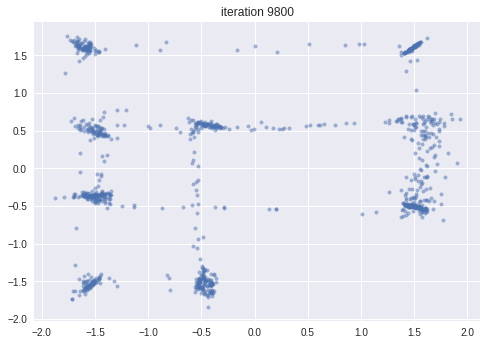

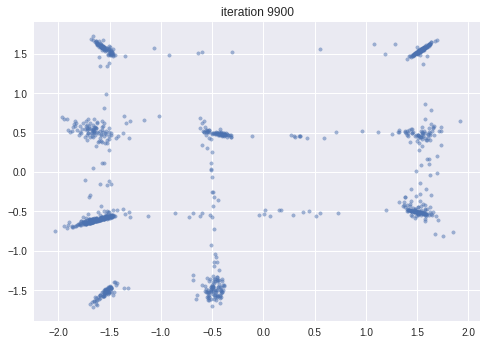

In [0]:
z_dim = 64

generator = MLP(z_dim, 2).cuda()
discriminator = MLP(2,1).cuda()

n_iter = int(1e+4)
batch_size = 300

disc_loss_hist = []
gen_loss_hist = []

lr_G = 2e-4
lr_D = 1e-4


optimizer_G = torch.optim.RMSprop(generator.parameters(), lr = lr_G)
optimizer_D = torch.optim.RMSprop(discriminator.parameters(), lr = lr_D)

loss = nn.BCEWithLogitsLoss()

k = 1

plot_freq = int(n_iter/100)

save = True  

# clean image store

if save:

  for fpath in os.listdir('./'):
    os.remove(fpath)
  
for it in tqdm(range(n_iter)):
  
  for i in range(k):
    
    discriminator.zero_grad()

    z = torch.randn([batch_size, z_dim]).cuda()
    x_fake = generator(z)
    x_real = x_real_gen(batch_size).cuda()
    disc_out_real = discriminator(x_real)
    disc_out_fake = discriminator(x_fake)

    # Loss
    disc_loss_real = loss(disc_out_real, torch.ones_like(disc_out_real).cuda())
    disc_loss_fake = loss(disc_out_fake, torch.zeros_like(disc_out_fake).cuda())

    disc_loss = disc_loss_real + disc_loss_fake
    disc_loss_hist += [disc_loss]

    disc_loss.backward()
    optimizer_D.step()
    
  generator.zero_grad() 
  
  z = torch.randn([batch_size, z_dim]).cuda()
  x_fake = generator(z)
  disc_out_fake = discriminator(x_fake)

  gen_loss = loss(disc_out_fake, torch.ones_like(disc_out_fake).cuda())
  gen_loss_hist += [gen_loss]
  
  gen_loss.backward()
  optimizer_G.step()
  
  if it%plot_freq == 0:
    
    n = 1000

    z = torch.randn([n, z_dim]).cuda()
    x_fake = generator(z).cpu().detach().numpy()

    plt.figure()
    plt.scatter(x_fake[:,0], x_fake[:,1], marker = '.', alpha = 0.5)
    plt.title('iteration {}'.format(it)) 
    
    if save:
    
      plt.savefig('./{}.png'.format(it))



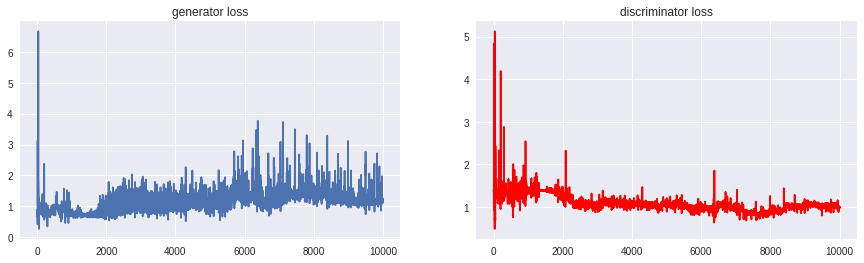

In [0]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, nrows = 1, figsize = (15,4))

ax1.plot(gen_loss_hist)
ax1.set_title('generator loss')
ax2.plot(disc_loss_hist, 'r')
ax2.set_title('discriminator loss')

plt.show()

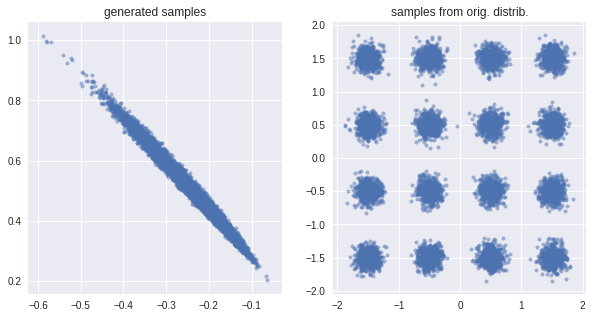

In [0]:
n = 10000

z = torch.randn([n, z_dim]).cuda()
x_fake = generator(z).cpu().detach().numpy()
x_real = x_real_gen(n)

fig, (ax1, ax2) = plt.subplots(ncols = 2, nrows = 1, figsize = (10,5))

ax1.scatter(x_fake[:,0], x_fake[:,1], marker = '.', alpha = 0.5)
ax1.set_title('generated samples')
ax2.scatter(x_real[:,0], x_real[:,1], marker = '.', alpha = 0.5)
ax2.set_title('samples from orig. distrib.')

plt.show()


We can observe mode collapse: 

# 1. With SGA

We will use just a simple GAN but with SGA binded with optimizer

Here is an algorithm of SGA from the paper:

![](https://cdn-ak.f.st-hatena.com/images/fotolife/t/toaruharunohi/20180926/20180926224437.png)

The main issue here is to compute the $\nabla H$ and $A^{\top}\xi $ 

In [0]:
# w1 = list(X1.parameters())
# w2 = list(X2.parameters())


# dl1dw1 =  flatten(fill(torch.autograd.grad(l1, w1, create_graph=True, allow_unused=True), w1))
# dl2dw2 =  flatten(fill(torch.autograd.grad(l2, w2, create_graph=True, allow_unused=True), w2))

# dl1dw1w1 = get_hess_block(dl1dw1, w1)
# dl1dw1w2 = get_hess_block(dl1dw1, w2)
# dl2dw2w1 = get_hess_block(dl2dw2, w1)
# dl2dw2w2 = get_hess_block(dl2dw2, w2)

# up = torch.cat((dl1dw1w1, dl1dw1w2.transpose(1,0)), dim = 1)
# down = torch.cat((dl2dw2w1.transpose(1,0), dl2dw2w2), dim = 1)

In [0]:
def flatten(tensor_seq):
    
  tens_flatten = tensor_seq[0].view(-1)

  for t in tensor_seq:

    tens_flatten = torch.cat((tens_flatten,t.view(-1)))
      
  return tens_flatten


def transpose(x):
  
  if len(x.shape) == 1:
    
    return x.view(-1,1)
  
  else:
    
    return x.transpose(1,0) 
  
  
def fill(x,w):

  new_x = []
  
  for i in range(len(x)):
    
    if type(x[i]) == type(None):
      
      new_x += [torch.zeros_like(w[i])]
      
    else:
      
      new_x += [x[i]]
      
  return new_x   


def get_hess_block(partial, variables):
  
  return torch.cat(tuple(flatten(fill(torch.autograd.grad(p, variables, create_graph=True, allow_unused=True), variables)).view(-1,1) for p in partial), 1)


def flatten(tensor_seq):
    
  tens_flatten = tensor_seq[0].view(-1)

  for t in tensor_seq:

    tens_flatten = torch.cat((tens_flatten,t.view(-1)))
      
  return tens_flatten
        

In [0]:
from torch.optim import Optimizer

class SGA(Optimizer):

    def __init__(self, params, lr=1e-2):
      
        
        self.lr = lr
        self.params = params
        self.params_flatten = flatten(params[0] + params[1])

    def step(self, loss, closure=None):
        """Performs a single optimization step.

        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        
    
        w1 = self.params[0]
        w2 = self.params[1]
        
        l1 = loss[0]
        l2 = loss[1]

        dl1dw1 =  flatten(fill(torch.autograd.grad(l1, w1, create_graph=True, allow_unused=True), w1))
        dl2dw2 =  flatten(fill(torch.autograd.grad(l2, w2, create_graph=True, allow_unused=True), w2))
        
        grads = torch.cat((dl1dw1, dl2dw2),0)
        
        H = 0.5*torch.norm( grads )**2
  
        nablaH = torch.autograd.grad(H, self.params_flatten, create_graph = True)

        dl1dw1w1 = get_hess_block(dl1dw1, w1)
        dl1dw1w2 = get_hess_block(dl1dw1, w2)
        dl2dw2w1 = get_hess_block(dl2dw2, w1)
        dl2dw2w2 = get_hess_block(dl2dw2, w2)

        up = torch.cat((dl1dw1w1, dl1dw1w2.transpose(1,0)), dim = 1)
        down = torch.cat((dl2dw2w1.transpose(1,0), dl2dw2w2), dim = 1)

        Hess = torch.cat((up,down),0)
        
        A = 0.5*(Hess - Hess.transpose(1,0))
        
        Atksi = A @ grads

        if sign:
          
          first_dot = torch.dot(grads, nablaH)
          second_dot = torch.dot(Atksi, nablaH)
          lbmd = torch.sign((first_dot * second_dot) / n + 1e-1)
          
        params += self.lr( grads +  lbmd*(Atksi @ grads))

In [0]:
z_dim = 64

generator = MLP(z_dim, 2).cuda()
discriminator = MLP(2,1).cuda()

n_iter = int(1e+2)
batch_size = 300

disc_loss_hist = []
gen_loss_hist = []

lr_G = 2e-4
lr_D = 1e-4

loss = nn.BCEWithLogitsLoss()

k = 1

plot_freq = int(n_iter/100)

save = True  

params = [list(generator.parameters()), list(discriminator.parameters())]

optimizer = SGA(params)

if save:

  for fpath in os.listdir('./'):
    os.remove(fpath)

  
for it in tqdm(range(n_iter)):
  
  discriminator.zero_grad()
  generator.zero_grad() 
  
  z = torch.randn([batch_size, z_dim]).cuda()
  x_fake = generator(z)
  x_real = x_real_gen(batch_size).cuda()
  disc_out_real = discriminator(x_real)
  disc_out_fake = discriminator(x_fake)

  # Disc Loss
  disc_loss_real = loss(disc_out_real, torch.ones_like(disc_out_real).cuda())
  disc_loss_fake = loss(disc_out_fake, torch.zeros_like(disc_out_fake).cuda())

  disc_loss = disc_loss_real + disc_loss_fake
  disc_loss_hist += [disc_loss]

  # Gen loss
  z = torch.randn([batch_size, z_dim]).cuda()
  x_fake = generator(z)
  disc_out_fake = discriminator(x_fake)

  gen_loss = loss(disc_out_fake, torch.ones_like(disc_out_fake).cuda())
  gen_loss_hist += [gen_loss]
  
  # Step
  optimizer.step([gen_loss, disc_loss])
  
  if it%plot_freq == 0:
    
    n = 1000

    z = torch.randn([n, z_dim]).cuda()
    x_fake = generator(z).cpu().detach().numpy()

    plt.figure()
    plt.scatter(x_fake[:,0], x_fake[:,1], marker = '.', alpha = 0.5)
    plt.title('iteration {}'.format(it)) 
    
    if save:
    
      plt.savefig('./{}.png'.format(it))

